# Pre-process US TMY3 Data - Multiple Sites

Input data are available through OpenEI 
[here](https://openei.org/datasets/dataset/commercial-and-residential-hourly-load-profiles-for-all-tmy3-locations-in-the-united-states).

In [9]:
from pathlib import Path
import numpy as np
import pandas as pd

raw_data_path = Path.home() / Path('Data/USA_commercial_openei/USA_CA_Oakland.Intl.AP.724930_TMY3')
output_path = Path('../data/US_multi_site_preprocessed')

## Parameters

In [2]:
timestep = 60 # minutes
freq = '{}min'.format(timestep)

# dictionary of sites. Each site has a list of buildings
sites_d = {'Hospital': ['Hospital'], 
           'Office': ['LargeOffice', 'QuickServiceRestaurant', 
                      'MediumOffice', 'LargeHotel', 'Warehouse'], 
           'School': ['PrimarySchool', 'SecondarySchool', 'SmallOffice', 'QuickServiceRestaurant'],
           'Residential': ['Supermarket', 'FullServiceRestaurant', 
                           'StripMall', 'MidriseApartment', 
                           'Supermarket', 'SmallHotel', 'Stand-aloneRetail']
          }

gas_to_heat_eff = 0.95
el_to_heat_eff = 2.5
el_to_cool_eff = 2.5

## Import Data

In [3]:
def get_openei_filename(building):
    return 'RefBldg{}New2004_7.1_5.0_3C_USA_CA_SAN_FRANCISCO.csv'.format(building)

In [4]:
index = pd.DatetimeIndex(start=pd.datetime(year,1,1), 
                         end=pd.datetime(year+1,1,1), 
                         freq=freq)[:-1]

load_d = {} # dictionary to store one dataframe per site

# all columns used as input
input_cols = ['electricity:facility', 'cooling:electricity', 
              'heating:electricity', 'gas:facility', 
              'interiorequipment:gas']

for site, buildings_l in sites_d.items():
    
    _site_load_df = pd.DataFrame(0, index=index, 
                                 columns=['electricity', 'heating', 'cooling'])
    
    for building in buildings_l:
        _filename = get_openei_filename(building)
        
        # load csv file
        _load_df = pd.read_csv(raw_data_path / _filename)
        
        # set datetime index
        _load_df.set_index(index, inplace=True)
            
        # remove spaces, unit and timestep from column names
        _load_df.columns = _load_df.columns \
            .str.replace(' ','') \
            .str.lower() \
            .str.replace('\[[\w]*\]', '') \
            .str.replace('\(hourly\)', '')
            
        # add missing columns (empty)
        for col in input_cols:
            if col not in _load_df.columns:
                _load_df[col] = 0
        
        # electricity demand
        _site_load_df.electricity += (_load_df['electricity:facility'] 
                                      - _load_df['cooling:electricity'] 
                                      - _load_df['heating:electricity'])
        
        # heating demand
        _site_load_df.heating += (_load_df['gas:facility'] * gas_to_heat_eff
                                  - _load_df['interiorequipment:gas'] * gas_to_heat_eff
                                  + _load_df['heating:electricity'] * el_to_heat_eff)
        
        # add cooling demand
        _site_load_df.cooling += _load_df['cooling:electricity'] * el_to_cool_eff
        
    load_d[site] = _site_load_df

In [5]:
electricity_df = pd.DataFrame(dict((building, _df.electricity) 
                                   for building, _df in load_d.items()))

heating_df = pd.DataFrame(dict((building, _df.heating) 
                                   for building, _df in load_d.items()))

cooling_df = pd.DataFrame(dict((building, _df.cooling) 
                               for building, _df in load_d.items()))

## Load Duration Curves

In [6]:
%matplotlib inline

from matplotlib import pyplot as plt
plt.style.use('ggplot')

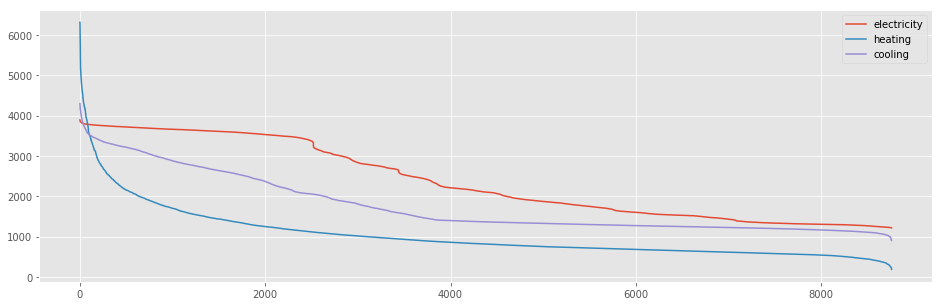

In [7]:
fig, ax = plt.subplots(figsize=(16,5))

electricity_df.sum(axis=1).sort_values(ascending=False).reset_index(drop=True).plot(
    figsize=(16,5), label='electricity', ax=ax)

heating_df.sum(axis=1).sort_values(ascending=False).reset_index(drop=True).plot(
    figsize=(16,5), label='heating', ax=ax)

cooling_df.sum(axis=1).sort_values(ascending=False).reset_index(drop=True).plot(
    figsize=(16,5), label='cooling', ax=ax)

ax.legend();

## Save Data

In [8]:
electricity_df.to_csv(output_path / 'electricity.csv', index=False, header=None, float_format='%.3f')
heating_df.to_csv(output_path / 'heating.csv', index=False, header=None, float_format='%.3f')
cooling_df.to_csv(output_path / 'cooling.csv', index=False, header=None, float_format='%.3f')